# CSC14116 - Changing image background

## Tổng quan
Làm mờ hay thay đổi background (hậu cảnh) là một trong những ứng dụng cần thiết trong bối cảnh hậu đại dịch Covid, khi mà ngày càng nhiều cuộc họp được thực hiện trực tuyến do sự tiện lợi của nó mà người dùng muốn có một không gian họp riêng tư ngay tại nơi mình đang ngồi mà không cần phải di chuyển đến một nơi khác.

Việc thay đổi background được nhóm xác định gồm 2 bước chính:
 1. Xác định phần khung viền bọc xung quanh người.
 2. Tùy theo làm mờ hay thay đổi background mà có thể nhân ma trận để làm mờ hoặc ghép hình người vào một khung cảnh khác.

## Động lực
Chúng tôi thấy việc thay đổi background là một tính năng cần thiết cho các ứng dụng họp online được sử dụng rộng rãi trong thời đại công nghệ hiện nay. Bên cạnh đó nhóm nhận thấy công việc này cũng có thể phân ra thành các bước áp dụng được song song hóa, từ đó cải thiện tốc độ xử lý vấn đề.

## Vì sao cần tăng tốc?
Việc thay đổi background nếu được thực hiện tuần tự trên CPU sẽ làm tốn rất nhiều thời gian do mỗi giây trên video tạo từ rất nhiều khung hình, mà mỗi khung đều có thể được quy về các bước để chạy song song mà CPU không thích hợp để chạy song song. Vì thể chúng tôi mong muốn có thể giả lập lại việc thay đổi background chạy song song trên GPU để tăng tốc quá trình xử lý, từ đó có thể đạt được hiệu năng như các ứng dụng họp online như Zoom, Google Meet, ...

## Khả năng chạy song song
1. Việc xác định khung viền bọc xung quanh người được thực hiện bằng việc đưa các khung hình qua model đã được huấn luyện trước. Mỗi khung hình được đưa qua các tầng của model, mà công việc chính là nhân ma trận nên có thể thực hiện việc song song hóa, từ đó có thể thiết kế để chạy song song.
2. Việc thay đổi background cũng có thể được thực hiện song song do việc xác định phần background sẽ được thực hiện bằng việc nhân với ma trận được xác định ở bước 1, việc thay đổi background mới cũng được thực hiện bằng việc nhân ma trận nên có thể song song hoá.

$\rightarrow$ Do đó có thể thiết kế song song cho toàn bộ quá trình. 

**Input:** Hình ảnh, video người dùng trong các cuộc họp trực tuyến và hình ảnh background người dùng muốn thay thế.

**Output:** Hình ảnh, video đã được thay đổi background.


<img src="https://user-images.githubusercontent.com/50958253/174557063-b2699158-4098-4929-b501-bc23eb55f2b0.png" alt="drawing" width="200"/> + <img src="https://user-images.githubusercontent.com/50958253/174557523-737ec1d9-5514-4a00-9d6f-6b0440eaf718.png" alt="drawing" width="200"/>
 = <img src="https://user-images.githubusercontent.com/50958253/174557505-e5784dcb-51b3-4c77-b6a7-36073d5a4e35.png" alt="drawing" width="200"/>

*Nguồn ảnh*: https://www.youtube.com/watch?v=pBIunR98d5I&t=143s




## Hướng tiếp cận 
Dựa trên 2 bước chính:
1. Cài đặt quá trình feedforward với bộ trọng số đã huấn luyện của mô hình U-Net để giải quyết bài toán human segmentation.

   Các tầng layer chính: Conv2d, BatchNormalization, Activation('relu'), MaxPool2D, Conv2dTranspose, Activation('sigmoid')

   Ngoài ra còn có hàm Concatenation.

2. Thay thế các pixel thuộc lớp background với hình ảnh người dùng muốn thay thế.
 
**Tuần tự:** viết code cho các layer sử dụng numpy.

**Song song:** sử dụng numba để tối ưu hóa code tuần tự.     

![zoom5](https://user-images.githubusercontent.com/47071155/174651030-3d2a6216-8f11-4ee7-953e-9dae594b5348.jpg)
![](https://drive.google.com/uc?id=1TL85Y-CO6cmJ1crPRnqAC7OQfywXrB9N)

_Ảnh kết quả khi xác định pixel của người dùng mô hình U-Net_

*Nguồn ảnh*: Google image



### Mô hình U-Net 

Đối với bài toán nhận diện người:
* **Input**: Bức ảnh RGB (256x256x3)
* **Output**: Segmentation mask, kích thước (256x256x1) có giá trị khoảng [0,1] và threshold = 0.5 \
Label người nếu threshold > 0.5

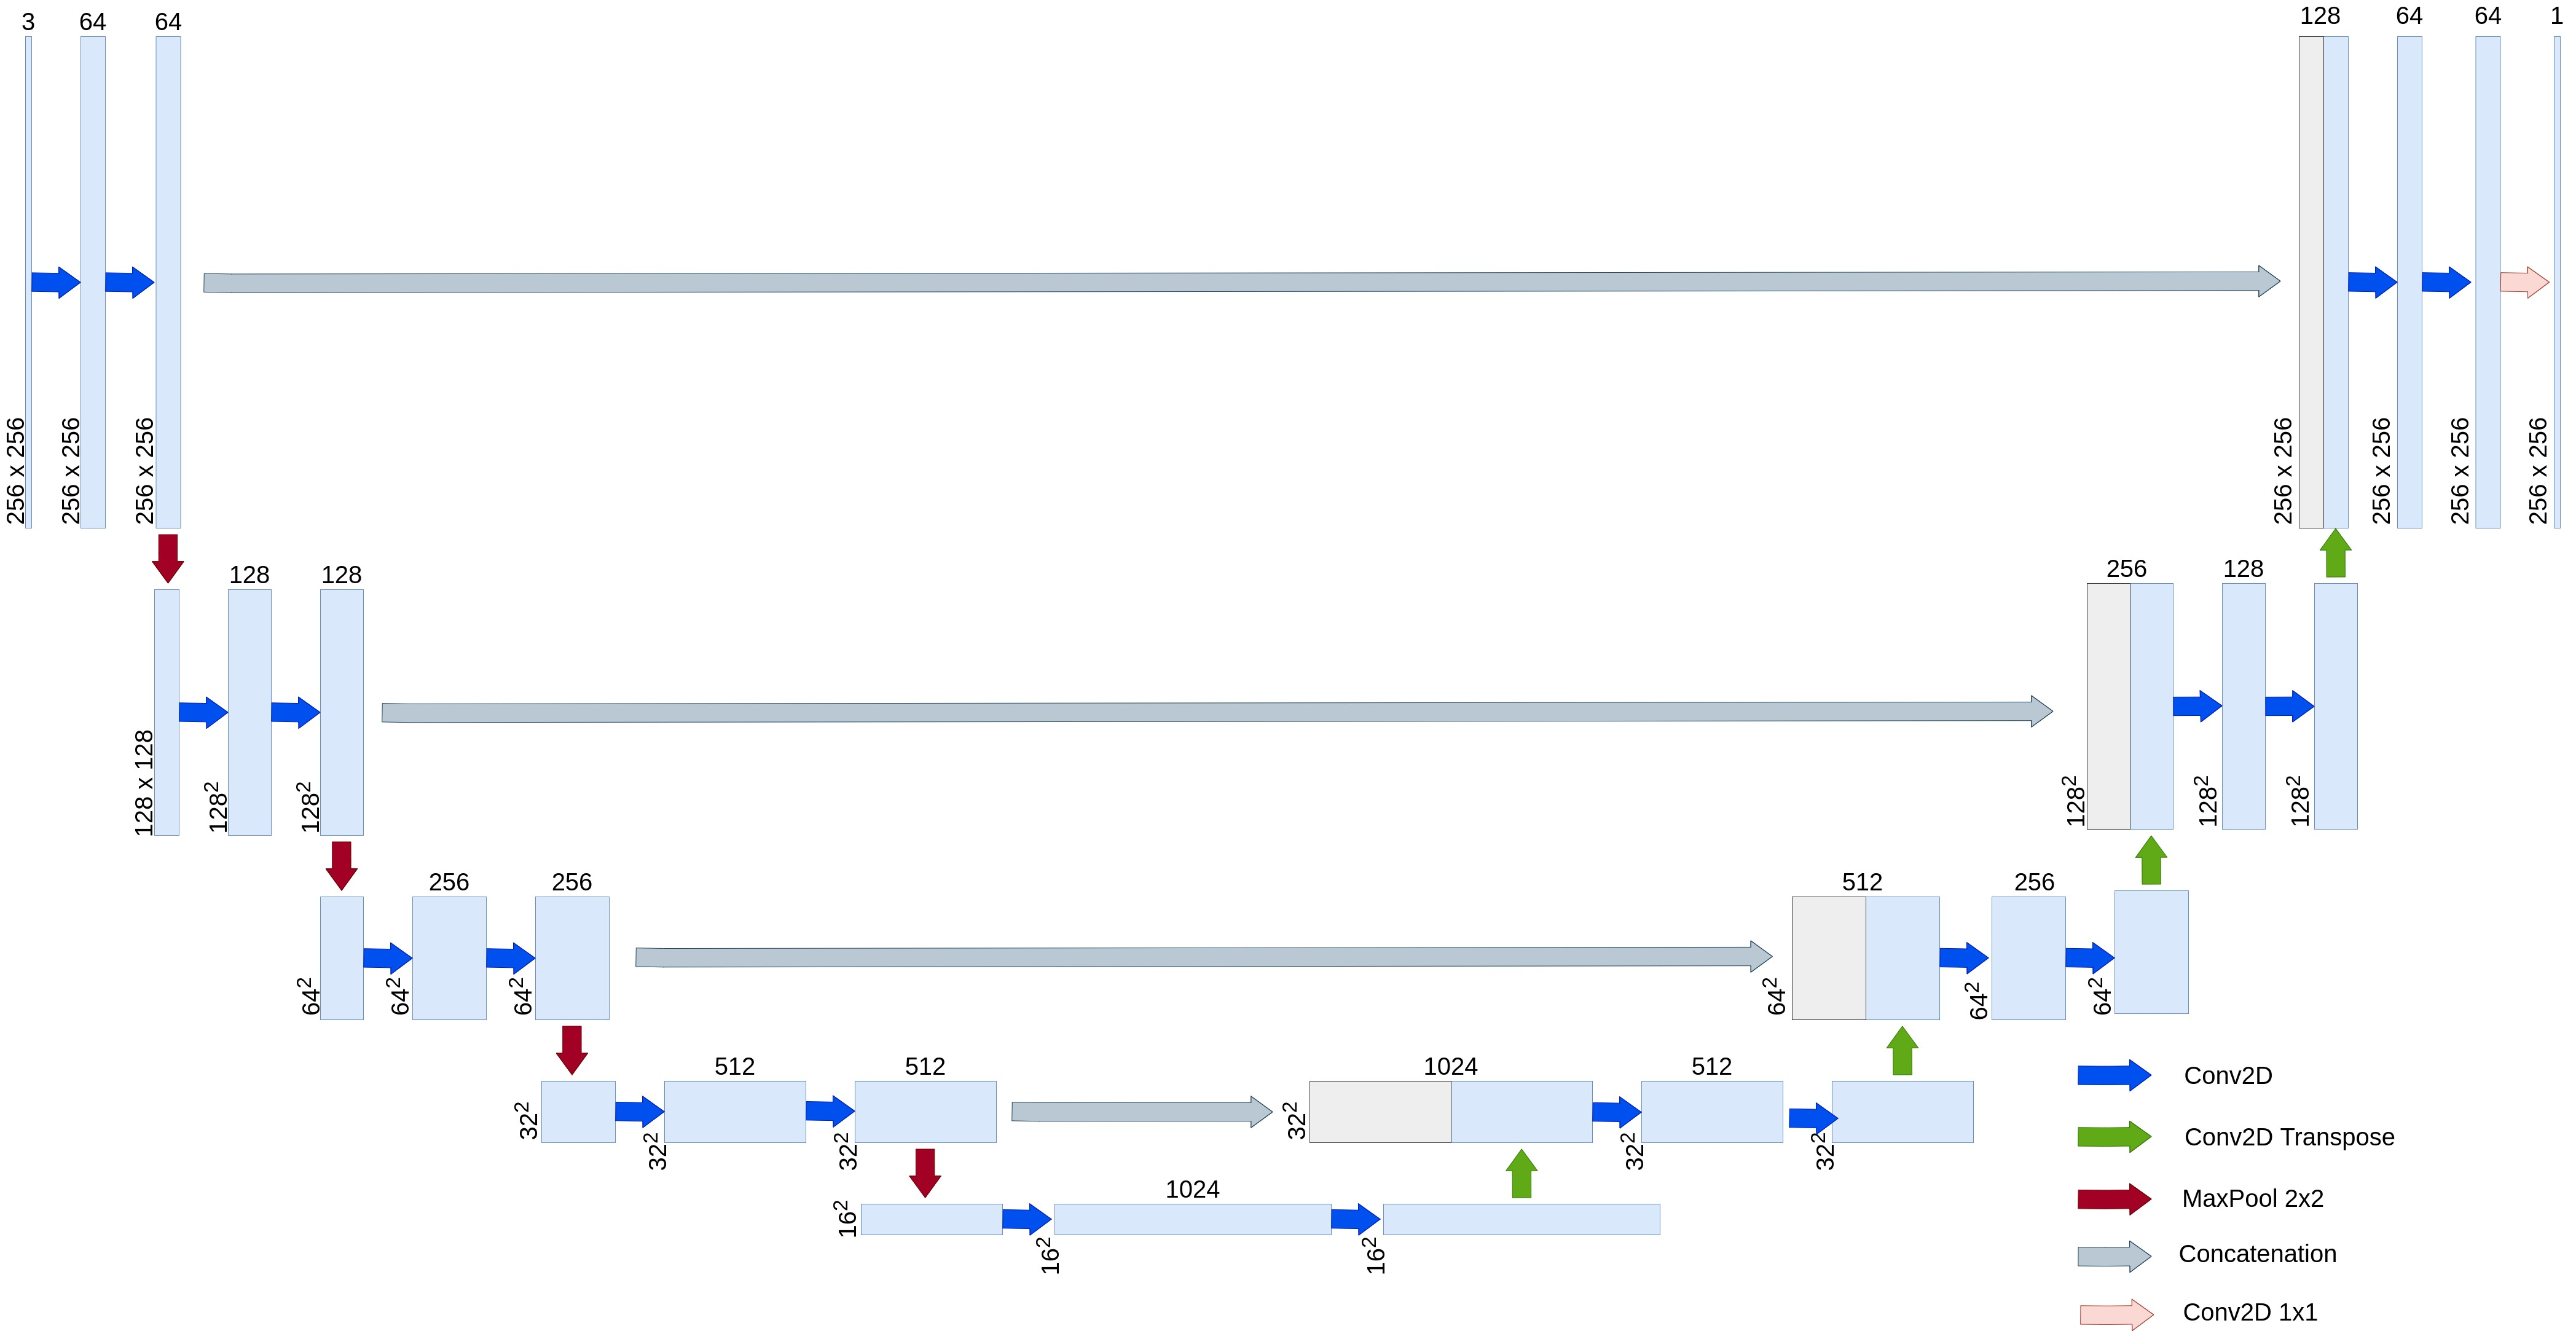

## Cài đặt tuần tự
Cài đặt sử dụng dòng lặp và câu điều kiện, không xài các hàm của numpy

### Thiết kế

**Ý tưởng chính:** 
* Tính kích thước và khởi tạo ma trận output.
* Sử dụng 3 vòng lặp tương ứng với depth, width, height để duyệt và tính kết quả cho từng phần tử của ma trận output.



**Activation("relu")** 

Công thức: $f(x) = max(0,x)$ \
* Kích thước ma trận output = input
* Với từng phần tử output: giá trị = 0 nếu x < 0

**MaxPool2D**

MaxPool2D là layer dùng để giảm kích thước của đặc trưng. 

*   Kích thước ma trận output: $O = \frac{I - poolsize}{stride}+1$ \
 $O$ : output's width/ height \
 $I$ : input's width/ height

* Với từng phần tử output: sử dụng 2 dòng for duyệt khu vực filter để tìm được giá trị maximum.


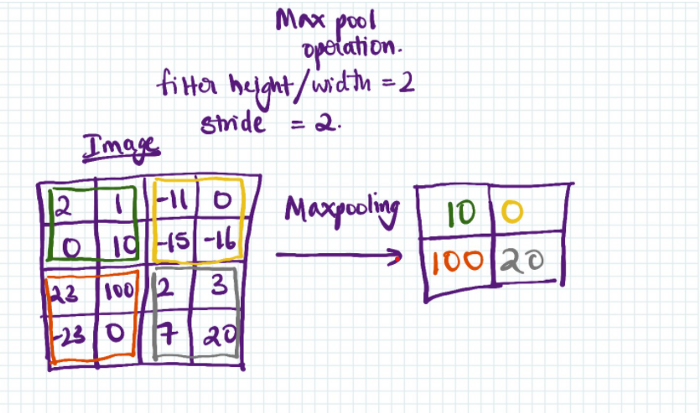

Nguồn ảnh: https://medium.com/@PAdhokshaja/simple-cnn-using-numpy-part-iii-relu-max-pooling-softmax-c03a3377eaf2

**Convolution 2D**

Convolution (lớp tích chập) là lớp trích xuất các đặc tính từ hình ảnh. Bằng cách trượt dần bộ lọc theo chiều ngang và dọc trên ảnh, chúng ta sẽ thu được một feature map chứa các đặc trưng được trích xuất từ trên hình ảnh đầu vào. \
*   Kích thước ma trận output: $O = \frac{I - K + 2*padding}{stride}+1$ \
 $O$ : output's width/ height \
 $I$ : input's width/ height \
 $K$ : kernel's width/ height
*   Với từng phần tử output: tính kết quả của phép tích chập ứng với phần tử hiện tại.



<img src="https://i.stack.imgur.com/BZHGo.png" alt="drawing" width="512"/>

*Nguồn ảnh*: https://stackoverflow.com/questions/43306323/keras-conv2d-and-input-channels

**Transpose Convolution 2D**

> Tham khảo: https://d2l.ai/chapter_computer-vision/transposed-conv.html

Lớp Tranpose Convolution là quá trình ngược lại của lớp Convolution. Convolution: biến đổi từ ảnh sang đặc trưng. Tranpose Convolution: biến đổi từ đặc trưng sang các pixel ảnh

Ngoài ra, có thể gia tăng kích thước đặc trưng một cách đơn giản thông qua Upsampling nhưng có thể gây mất mát thông tin. 
*   Kích thước ma trận output: $O = (I - 1)*stride + K + padding$ \
*   Với từng phần tử output: tính phép tích chập đảo cho từng phần tử.


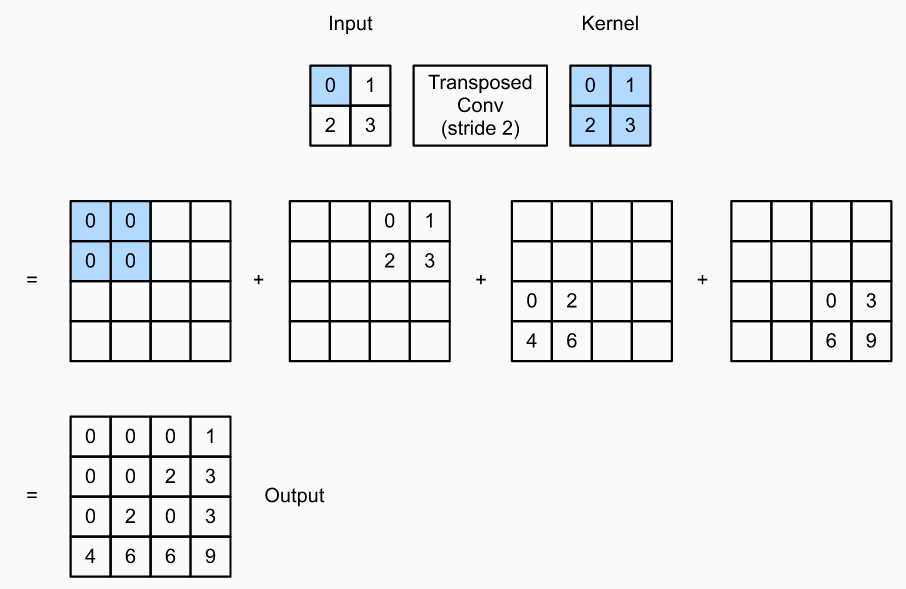

Nguồn ảnh: https://d2l.ai/chapter_computer-vision/transposed-conv.html

**Batch Normalization**

Lớp Batch Normalization dùng để chuẩn hóa các giá trị của đặc trưng. Nhóm thao khảo công thức tầng Batch Normalization của [thư viện keras](https://keras.io/api/layers/normalization_layers/batch_normalization/)

* Kích thước ma trận output = input
* Với từng phần tử output: chuẩn hóa giá trị dựa trên công thức dưới đây.

Công thức: 

$$ \frac{\gamma * (x - moving\_mean)}{\sqrt{moving\_var + \epsilon}} + \beta $$

*Các hệ số được cập nhật trong quá trình học*:
* $\gamma$ : hệ số scaling.
* $\beta$ : hệ số offset (xê dịch).
* $\epsilon$ : hằng số nhỏ để đảm bảo chia với số không âm.
* $𝑚𝑜𝑣𝑖𝑛𝑔\_𝑚𝑒𝑎𝑛$ : là tham số mean được học để chuẩn hóa giá trị.
* $𝑚𝑜𝑣𝑖𝑛𝑔\_𝑣𝑎𝑟$ : là tham số variance được học để chuẩn hóa giá trị.





**Concatenation**

Lớp Concatenation dùng để tạo skip-connection giúp cho việc truyền gradient về các lớp đầu tốt hơn. Cải thiện quá trình học của mô hình. 

* Kích thước ma trận output: $(1, InputWidth, InputHeight, InputDepth*2)$
* Với từng phần tử: gán thành giá trị của feature map hoặc skip-features dựa vào chỉ số hiện tại của depth



### Cài đặt

#### Sử dụng thư viện kiểm tra

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/LTSS

/content/drive/MyDrive/LTSS


In [3]:
from tensorflow import keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, MaxPool2D
import numpy as np
import cv2
from keras import backend as K
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import math
from time import time
from numba import jit, prange, config, cuda, float32
import pandas as pd

In [4]:
def read_image(path):
    origin_img = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = origin_img.shape
    x = cv2.resize(origin_img, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    # (256, 256, 3)
    return x, w, h, origin_img

In [5]:
# Read input and build model
x, x_w, x_h, origin_img = read_image("./Images/zoom5.jpg")
x = np.expand_dims(x, axis=0)

In [6]:
model = tf.keras.models.load_model("./Model_20/unet.h5")

In [7]:
# Create variables for checking 
from keras import backend as K
inp = model.input                                       # input placeholder
outputs = [layer.output for layer in model.layers]      # all layer outputs
functors = [K.function(inp, out) for out in outputs]    # evaluation functions

# Layers weights
layer_outs = [func(x) for func in functors]

In [8]:
for i, layer in enumerate(model.layers):
    print(i,layer.name, layer_outs[i].shape)

0 input_2 (1, 256, 256, 3)
1 conv2d_19 (1, 256, 256, 64)
2 batch_normalization_18 (1, 256, 256, 64)
3 activation_18 (1, 256, 256, 64)
4 conv2d_20 (1, 256, 256, 64)
5 batch_normalization_19 (1, 256, 256, 64)
6 activation_19 (1, 256, 256, 64)
7 max_pooling2d_4 (1, 128, 128, 64)
8 conv2d_21 (1, 128, 128, 128)
9 batch_normalization_20 (1, 128, 128, 128)
10 activation_20 (1, 128, 128, 128)
11 conv2d_22 (1, 128, 128, 128)
12 batch_normalization_21 (1, 128, 128, 128)
13 activation_21 (1, 128, 128, 128)
14 max_pooling2d_5 (1, 64, 64, 128)
15 conv2d_23 (1, 64, 64, 256)
16 batch_normalization_22 (1, 64, 64, 256)
17 activation_22 (1, 64, 64, 256)
18 conv2d_24 (1, 64, 64, 256)
19 batch_normalization_23 (1, 64, 64, 256)
20 activation_23 (1, 64, 64, 256)
21 max_pooling2d_6 (1, 32, 32, 256)
22 conv2d_25 (1, 32, 32, 512)
23 batch_normalization_24 (1, 32, 32, 512)
24 activation_24 (1, 32, 32, 512)
25 conv2d_26 (1, 32, 32, 512)
26 batch_normalization_25 (1, 32, 32, 512)
27 activation_25 (1, 32, 32, 512)

In [9]:
def check(func, *arg):
    start = time()
    result = func(*arg)
    end = time()
    t = end - start
    return result, t

time_compile = np.zeros(7, dtype=float)
time_run = np.zeros(7, dtype=float)
time_unet = np.zeros(7, dtype=float)
time_parallel = np.zeros(7, dtype=float)
func = ['Relu', 'Sigmoid', 'Maxpool2D', 'Conv2D', 'Conv2D Transpose', 'Batch Norm', 'Concat']

#### Activation ("relu")

In [10]:
@jit(cache=True)
def relu(x):
    for d in range(x.shape[3]):
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                if x[:,i,j,d]<0:
                    x[:,i,j,d]=0
    return x

In [11]:
# Check  answer
before = np.array(layer_outs[2])
after = np.array(layer_outs[3])

i = 0
res, t = check(relu, before)
time_compile[i] += t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 0.0


In [12]:
_, t = check(relu, before)
time_run[i] += t

#### Activation ("sigmoid")

In [13]:
@jit(cache=True)
def sigmoid(x):
    for d in range(x.shape[3]):
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                x[:,i,j,d]= 1 / (1 + np.exp(-x[:,i,j,d]))
    return x 

In [14]:
before = np.array(layer_outs[2])
after = 1 / (1 + np.exp(-layer_outs[2]))

i += 1
res, t = check(sigmoid, before)
time_compile[i] += t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 1.4138188e-08


In [15]:
_, t = check(sigmoid, before)
time_run[i] += t

#### MaxPool2D

In [16]:
@jit(cache=True)
def maxpool2d(x, pool_size = 2,stride = 2):
    # Input dim (1,256,256,3)
    output_width = output_height = int((x.shape[1]-pool_size)/stride)+1
    pooled = np.zeros((1,output_width,output_height,x.shape[3]))

    # Iterate over all pools
    for d in range(x.shape[3]):
        for i in range(0,x.shape[1], stride):
            for j in range(0, x.shape[2], stride):
                if i+pool_size <= x.shape[1] and j+pool_size <= x.shape[1]:
                    mat = x[:,i:i+pool_size, j:j+pool_size, d]
                    pooled[:,int(i/stride),int(j/stride),d]=np.max(mat)
                else:
                    raise Exception("Out of index")  
    return pooled

In [17]:
# Check  answer
before = np.array(layer_outs[6])
after = np.array(layer_outs[7])

i += 1
res, t = check(maxpool2d, before)
time_compile[i] = t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 0.0


In [18]:
_, t = check(maxpool2d, before)
time_run[i] = t

#### Conv2D

In [19]:
@jit(cache=True)
def conv2D(input, wei, bias, padding='valid', stride=1):
    w_in, h_in, c_in = input.shape[1], input.shape[2], input.shape[3]
    k = wei.shape[1] # kernel size
    pad = k // 2 if (padding == 'same') else 0
    w_out = (w_in + 2 * pad - k)//stride + 1
    h_out = (h_in + 2 * pad - k)//stride + 1
    c_out = bias.shape[0]

    input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
    input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = input

    res=np.zeros((1, w_out, h_out, c_out))

    for x in range(w_out): 
        for y in range(h_out):
            for c_o in range(c_out):
                total=0.
                for c_i in range(c_in):
                    kt=0.
                    for k_x in range(k):
                        for k_y in range(k):
                            pos1 = k_x + x * stride
                            pos2 = k_y + y * stride
                            kt += wei[k_x, k_y, c_i, c_o] * input_pad[0, pos1, pos2, c_i]
                    total += kt
                res[0, x, y, c_o] = total + bias[c_o]
    return res

In [20]:
before = np.array(x)
after = np.array(layer_outs[1])
weight = model.layers[1].weights[0].numpy()
bias = model.layers[1].weights[1].numpy()

i += 1
res, t = check(conv2D, before, weight, bias, 'same')
time_compile[i] = t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 1.000238593617159e-08


In [21]:
_, t= check(conv2D, before, weight, bias, 'same')
time_run[i] = t

#### Conv2D Transpose

In [22]:
@jit(cache=True)
def conv2Dtranspose(input, wei, bias, padding='none', stride=1):
    w_in, h_in, c_in = input.shape[1], input.shape[2], input.shape[3]
    k = wei.shape[1] # kernel size

    w_out = w_in*stride
    h_out = h_in*stride
    c_out = bias.shape[0]
    res = np.zeros((1, w_out, h_out, c_out))

    for c_o in range(c_out):
        for x in range(w_in): 
            for y in range(h_in):
                ker = np.zeros((k, k))
                for c_i in range(c_in):
                    for k_x in range(k):
                        for k_y in range(k):
                            ker[k_x, k_y] += wei[k_x, k_y, c_o, c_i] * input[0, x, y, c_i]
                res[0, x*stride: x*stride + k, 
                    y*stride: y*stride + k, c_o] += ker + bias[c_o]
    return res

In [23]:
before = np.array(layer_outs[34])
after = np.array(layer_outs[35])
weight = model.layers[35].weights[0].numpy()
bias = model.layers[35].weights[1].numpy()

i += 1
res, t = check(conv2Dtranspose, before, weight, bias, "same", 2)
time_compile[i] = t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 2.4055444530024147e-07


In [24]:
_, t= check(conv2Dtranspose, before, weight, bias, "same", 2)
time_run[i] = t

#### Batch Normalization

In [25]:
@jit(cache=True)
def batchNorm(X, gamma, beta, mov_mean, mov_var):
    eps = 0.001
    Y = X.copy()
    for d in range(X.shape[3]):
        for i in range(X.shape[1]):
            for j in range(X.shape[2]):
                Y[:,i,j,d] = (gamma[d]*(Y[:,i,j,d] - mov_mean[d]) / np.sqrt(mov_var[d] + eps))+ beta[d]
    return Y

In [26]:
before = np.array(layer_outs[1])
after = np.array(layer_outs[2])

wei = model.layers[2].weights
gamma = wei[0].numpy()
beta = wei[1].numpy()
moving_mean = wei[2].numpy()
moving_var = wei[3].numpy()

i += 1
res, t = check(batchNorm, before, gamma, beta, moving_mean, moving_var)
time_compile[i] = t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 3.423659e-08


In [27]:
_, t= check(batchNorm, before, gamma, beta, moving_mean, moving_var)
time_run[i] = t

#### Concatenation

In [28]:
@jit(cache=True)
def concat(skip_features, x):
    w_in, h_in, c_in = x.shape[1] ,x.shape[2] ,x.shape[3]
    Y = np.zeros((1,w_in, h_in, c_in*2))
    for d in range(Y.shape[3]):
        for i in range(Y.shape[1]):
            for j in range(Y.shape[2]):
              if d<c_in:
                Y[:,i,j,d] = x[:,i,j,d]
              else:
                Y[:,i,j,d] = skip_features[:,i,j,d-c_in]
    return Y

In [29]:
before = np.array(layer_outs[59])
after = np.array(layer_outs[60])

i += 1
res, t = check(concat, np.array(layer_outs[6]), before)
time_compile[i] = t
print("Checking difference:", np.abs(res-after).mean())

Checking difference: 0.0


In [30]:
_, t = check(concat, np.array(layer_outs[6]), before)
time_run[i] = t

#### Mô hình U-Net
> Tham khảo: 
https://www.kaggle.com/code/kiranshahi/unet-implementation/notebook



In [31]:
# load weight to dictionary
weights = {}
for i, layer in enumerate(model.layers):
    if "conv2d_transpose" in layer.name: 
        weights[i] = {"name":layer.name, "wei": layer.weights[0].numpy(),"bias": layer.weights[1].numpy()} 
    elif "conv2d" in layer.name: 
        weights[i] = {"name":layer.name, "wei": layer.weights[0].numpy(),"bias": layer.weights[1].numpy()}
    elif "batch_normalization" in layer.name:
        weights[i] = {"name":layer.name,
                      "gamma":layer.weights[0].numpy(),
                      "beta":layer.weights[1].numpy(), 
                      "moving_mean":layer.weights[2].numpy(),
                      "moving_var":layer.weights[3].numpy()}
      

In [32]:
def conv_block(inputs, index):
    x, t = check(conv2D, inputs, weights[index]["wei"], weights[index]["bias"], 'same')
    time_unet[3] += t
    x, t = check(batchNorm, x, weights[index+1]["gamma"], weights[index+1]["beta"], weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    time_unet[5] += t
    x, t = check(relu, x)
    time_unet[0] += t

    index += 3
    x, t = check(conv2D, x, weights[index]["wei"], weights[index]["bias"], 'same')
    time_unet[3] += t
    x, t = check(batchNorm, x, weights[index+1]["gamma"], weights[index+1]["beta"], weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    time_unet[5] += t
    x, t = check(relu, x)
    time_unet[0] += t
    
    return x

In [33]:
def encoder_block(inputs, index):
    print("encoder_block", index)
    x = conv_block(inputs, index)
    p, t = check(maxpool2d, x)
    time_unet[2] += t
    return x, p

In [34]:
def decoder_block(inputs, skip_features, index):
    print("decoder_block",index)
    x, t = check(conv2Dtranspose, inputs, weights[index]["wei"], weights[index]["bias"], "same", 2)
    time_unet[4] += t
    x, t = check(concat, skip_features, x)
    time_unet[6] += t
    x = conv_block(x, index + 2)
    return x

In [35]:
def build_unet(X):
    index = 1
    """ Encoder """
    s1, p1 = encoder_block( X, index ) #64
    index += 7
    s2, p2 = encoder_block( p1, index ) #128
    index += 7
    s3, p3 = encoder_block( p2, index ) #256
    index += 7
    s4, p4 = encoder_block( p3, index ) #512
    index += 7
    b1 = conv_block( p4, index ) #1024
    index += 6
    """ Decoder """
    d1 = decoder_block( b1, s4, index ) #512
    index += 8
    d2 = decoder_block( d1, s3, index ) #256
    index += 8
    d3 = decoder_block( d2, s2, index ) #128
    index += 8
    d4 = decoder_block( d3, s1, index ) #64 
    index += 8

    """ Output """
    # outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    flatten, t = check(conv2D, d4, weights[index]["wei"], weights[index]["bias"], "same", 1)
    time_unet[3] += t
    outputs, t = check(sigmoid, flatten)
    time_unet[1] += t
    return outputs

In [36]:
%time pred = build_unet(x)

encoder_block 1
encoder_block 8
encoder_block 15
encoder_block 22
decoder_block 35
decoder_block 43
decoder_block 51
decoder_block 59
CPU times: user 6min 32s, sys: 1.25 s, total: 6min 33s
Wall time: 6min 34s


In [37]:
pred_mask = cv2.resize(pred[0], (x_w, x_h))
pred_mask = np.expand_dims(pred_mask, axis=-1)
pred_mask = pred_mask > 0.5

background_mask = np.abs(1- pred_mask)
    
masked_image = origin_img * pred_mask

background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
background_mask = background_mask * [0, 0, 0]

masked_image = masked_image + background_mask
cv2.imwrite("result.png", masked_image)

True

### Đánh giá

#### Độ chính xác

Kết quả được feedforward hình qua mô hình tuần tự:



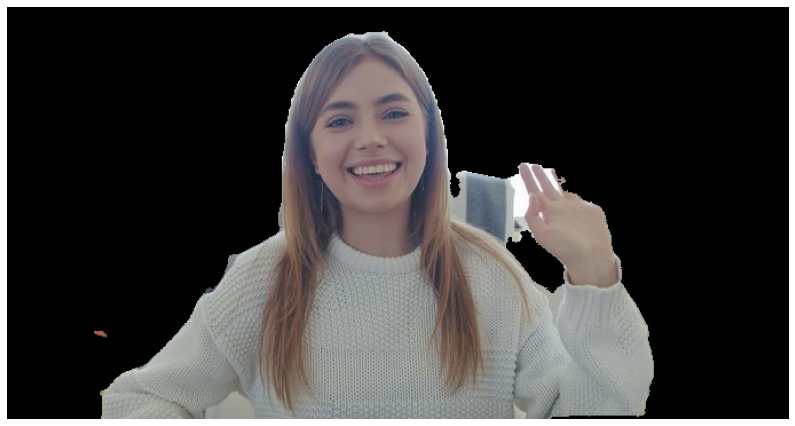

In [38]:
plt.figure(figsize=(14,8))
image = mpimg.imread("result.png")
plt.axis('off')
plt.imshow(image)
plt.show()

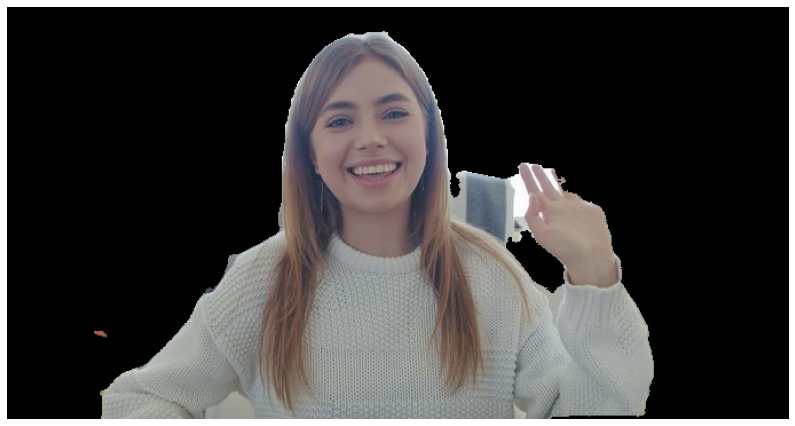

In [39]:
plt.figure(figsize=(14,8))
img_1 = mpimg.imread("Images/result_unet.png")
plt.axis('off')
plt.imshow(img_1)
plt.show()

In [40]:
np.abs(image - img_1).sum()

0.0

#### Thời gian chạy

In [41]:
pd.DataFrame(list(zip(func, time_compile, time_run, time_unet)),
               columns =['Name', 'Compile+Run', 'Run', 'Unet']).sort_values(by=['Unet'], ascending=False)

,Name,Compile+Run,Run,Unet
3,Conv2D,1.426897,0.478317,368.643209
4,Conv2D Transpose,4.267578,3.489094,15.074087
5,Batch Norm,0.907569,0.559728,5.289128
0,Relu,3.073246,0.381951,3.397863
2,Maxpool2D,0.943333,0.062136,0.708682
6,Concat,0.753933,0.220589,0.644811
1,Sigmoid,0.617574,0.311697,0.304038


## Cài đặt song song

### Phân tích 

Nhóm nhận thấy tổng thời gian mô hình U-Net chạy feedforward là **2m50s**. Để tăng tốc đáng kể thời gian dự đoán của mô hình, nhóm sẽ thực hiện song song cho tất cả các layer. \
Các layer được song song hóa:


1.   Activation ("relu")
2.   Activation ("sigmoid")
3.  MaxPool2D
4. Conv2D
5. Conv2D Transpose
6. Batch Normalization
7. Concatenation



### Thiết kế
**Ý tưởng chính**: Với output có kích thước $w' \times h' \times d'$, mỗi thread sẽ thực hiện tính giá trị cho từng phần tử của ma trận output.

### Cài đặt

In [42]:
print(cuda.detect())
BLOCK_SIZE = (8, 8, 8)

time_compile_parallel = np.zeros(7, dtype=float)
time_run_parallel = np.zeros(7, dtype=float)
time_unet_parallel = np.zeros(7, dtype=float)

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-cbba016b-75e7-8452-d475-c4dc012042f3
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
True


#### Activation ("relu") Parallel

In [43]:
@cuda.jit(debug=True) 
def relu_parallel(input, output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        if input[0, x, y, z] < 0: 
            output[0, x, y, z] = 0
        else: output[0, x, y, z] = input[0, x, y, z]

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [44]:
before = np.array(layer_outs[2])
after = np.array(layer_outs[3])

In [45]:
def relu_host(before):
  res = np.zeros((before.shape), dtype=float)
  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _ = relu_parallel[GRID_SIZE, BLOCK_SIZE](before, res)
  return res

In [46]:
i=0
res, t = check(relu_host,before)
time_compile_parallel[i] += t
print("Checking difference", np.abs(res-after).mean())  

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function relu_parallel at 0x7faafe499f80>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: relu_parallel)
  warn(NumbaInvalidConfigWarning(msg))


Checking difference 0.0


/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [47]:
res,t = check(relu_host,before)
time_run_parallel[i] += t

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


#### Activation ("sigmoid") Parallel

In [48]:
@cuda.jit(debug=True) 
def sigmoid_parallel(input, output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        output[0, x, y, z] = 1 / (1 + math.exp(-input[0, x, y, z]))

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [49]:
before = np.array(layer_outs[2])
after = 1 / (1 + np.exp(-layer_outs[2]))

In [50]:
def sigmoid_host(before):
  res = np.zeros((before.shape), dtype=float)
  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _ = sigmoid_parallel[GRID_SIZE, BLOCK_SIZE]( before, res)
  return res

In [51]:
i+=1
res,t = check(sigmoid_host,before)
time_compile_parallel[i] += t
print("Checking difference",np.abs(res-after).mean())

Checking difference 1.9653441007635214e-08


/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function sigmoid_parallel at 0x7faaa83f38c0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: sigmoid_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [52]:
res,t = check(sigmoid_host,before)
time_run_parallel[i] += t

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


#### MaxPool2D Parallel

In [53]:
@cuda.jit(debug=True)
def maxpool2d_parallel(input, output, pool, stride):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        col = x * stride
        row = y * stride

        max = input[0, col, row, z]
        for i in range(pool):
            for j in range(pool):
                if input[0, col + i, row + j, z] > max:
                    max = input[0, col + i, row + j, z]

        output[0, x, y, z] = max

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [54]:
before = np.array(layer_outs[6])
after = np.array(layer_outs[7])

In [55]:
def maxpool2d_host(before, pool = 2, stride = 2):

  w_out = (before.shape[1] - pool)//stride + 1
  h_out = (before.shape[2] - pool)//stride + 1
  res = np.zeros((1, w_out, h_out, before.shape[3]))

  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _ = maxpool2d_parallel[GRID_SIZE, BLOCK_SIZE]( before, res, pool, stride)
  return res
  

In [56]:
i+=1
res , t = check(maxpool2d_host,before)
time_compile_parallel[i] += t
print("Checking difference",np.abs(res-after).mean())

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function maxpool2d_parallel at 0x7faaa840e7a0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: maxpool2d_parallel)
  warn(NumbaInvalidConfigWarning(msg))


Checking difference 0.0


/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [57]:
res , t = check(maxpool2d_host,before)
time_run_parallel[i] += t

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


#### Conv2D Parallel

In [58]:
@cuda.jit(debug=True)
def conv2D_parallel(input, wei, bias, stride,output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        k = wei.shape[1]
        c_in = input.shape[3]

        total=0.
        for c_i in range(c_in):
            kt=0.
            for k_x in range(k):
                for k_y in range(k):
                    pos1 = k_x + x * stride
                    pos2 = k_y + y * stride
                    kt += wei[k_x, k_y, c_i, z] * input[0, pos1, pos2, c_i]
            total += kt
        
        output[0, x, y, z] = total + bias[z]

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [59]:
before = np.array(x)
after = np.array(layer_outs[1])
weight = model.layers[1].weights[0].numpy()
bias = model.layers[1].weights[1].numpy()

In [60]:
def conv2D_host(before, weight, bias ,padding ="same", stride = 1):
  w_in, h_in, c_in = before.shape[1:4]

  k = weight.shape[1]
  pad = k // 2
  w_out = (w_in + 2 * pad - k)//stride + 1
  h_out = (h_in + 2 * pad - k)//stride + 1
  c_out = bias.shape[0]

  input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
  input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

  res = np.zeros((1, w_out, h_out, c_out))
  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _=conv2D_parallel[GRID_SIZE, BLOCK_SIZE]( input_pad,  weight, bias, stride,res)
  return res


In [61]:
i+=1
res,t = check(conv2D_host,before, weight, bias)
time_compile_parallel[i] += t
print("Checking difference",np.abs(res-after).mean())

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function conv2D_parallel at 0x7faafe57e290>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2D_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Checking difference 1.000238593617159e-08


In [62]:
res,t = check(conv2D_host,before, weight, bias)

time_run_parallel[i] += t

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


#### Conv2D Transpose Parallel


In [63]:
@cuda.jit(debug=True)
def conv2Dtranspose_parallel(input, output, wei, bias, stride):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        # k = wei.shape[1]
        c_in = input.shape[3]

        total=0.
        k_x = x % stride
        k_y = y % stride
        for c_i in range(c_in):
            total += wei[k_x, k_y, z, c_i] * input[0, x // stride, y // stride, c_i]
        
        output[0, x, y, z] = total + bias[z]

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [64]:
before = np.array(layer_outs[34])
after = np.array(layer_outs[35])
weight = model.layers[35].weights[0].numpy()
bias = model.layers[35].weights[1].numpy()

In [65]:
def conv2Dtranspose_host(before, weight, bias,padding="same" , stride = 1):
  w_in, h_in, c_in = before.shape[1:4]

  stride = 2
  k = weight.shape[1]
  w_out = w_in * stride
  h_out = h_in * stride
  c_out = bias.shape[0]

  res = np.zeros((1, w_out, h_out, c_out))
  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _ = conv2Dtranspose_parallel[GRID_SIZE, BLOCK_SIZE]( before, res, weight, bias, stride)
  return res


In [66]:
i+=1
res,t = check(conv2Dtranspose_host,before, weight, bias)
time_compile_parallel[i] += t
print("Checking difference",np.abs(res-after).mean())

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function conv2Dtranspose_parallel at 0x7faafe333200>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2Dtranspose_parallel)
  warn(NumbaInvalidConfigWarning(msg))


Checking difference 2.4055444530024147e-07


/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [67]:
res,t = check(conv2Dtranspose_host,before, weight, bias)

time_run_parallel[i] += t

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


#### Batch Normalization Parallel

In [68]:
@cuda.jit(debug=True)
def batchNorm_parallel(X, eps, gamma, beta, moving_mean, moving_var, res):
    i,j,d = cuda.grid(3)

    res[0,i,j,d] = (gamma[d]*(res[0,i,j,d] - moving_mean[d]) / math.sqrt(moving_var[d] + eps))+ beta[d]

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [69]:
before = np.array(layer_outs[1])
after = np.array(layer_outs[2])

wei = model.layers[2].weights
gamma = wei[0].numpy()
beta = wei[1].numpy()
moving_mean = wei[2].numpy()
moving_var = wei[3].numpy()

In [70]:
def batchNorm_host(before, gamma, beta, moving_mean,moving_var):
  # ----
  eps = 0.001
  res = before.copy()
  # ----

  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))

  _ = batchNorm_parallel[GRID_SIZE, BLOCK_SIZE]( before, eps, gamma, beta, moving_mean, moving_var, res)
  return res


In [71]:
i+=1
res,t = check(batchNorm_host,before, gamma, beta, moving_mean,moving_var)
time_compile_parallel[i] += t
print("Checking difference",np.abs(res-after).mean())

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function batchNorm_parallel at 0x7faaa96ac170>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: batchNorm_parallel)
  warn(NumbaInvalidConfigWarning(msg))


Checking difference 3.423659e-08


/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [72]:
res,t = check(batchNorm_host,before, gamma, beta, moving_mean,moving_var)

time_run_parallel[i] += t

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


#### Concatenation

In [73]:
@cuda.jit(debug=True)
def concat_parallel(skip_features, x, res):
    i,j,d = cuda.grid(3)
    
    if d<x.shape[3]:
      res[0,i,j,d] = x[0,i,j,d]
    else:
      res[0,i,j,d] = skip_features[0,i,j,d-x.shape[3]]

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))


In [74]:
def concat_host(skip_features,before):
  w_in, h_in, c_in = before.shape[1] ,before.shape[2] ,before.shape[3]
  res = np.zeros((1,w_in, h_in, c_in*2))

  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _ = concat_parallel[GRID_SIZE, BLOCK_SIZE]( skip_features, before,res)
  return res

In [75]:
before = np.array(layer_outs[59])
after = np.array(layer_outs[60])
skip_features = np.array(layer_outs[6])

In [76]:
i+=1
res,t = check(concat_host,skip_features,before)
time_compile_parallel[i] += t
print("Checking difference:", np.abs(res-after).mean())

/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function concat_parallel at 0x7faafe20c4d0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: concat_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Checking difference: 0.0


In [77]:
res,t = check(concat_host,skip_features,before)

time_run_parallel[i] += t

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


#### Mô hình U-Net song song
> Tham khảo: 
https://www.kaggle.com/code/kiranshahi/unet-implementation/notebook



In [78]:
def conv_block(inputs, index):
    x, t = check(conv2D_host, inputs, weights[index]["wei"], weights[index]["bias"], 'same')
    time_unet_parallel[3] += t
    x, t = check(batchNorm_host, x, weights[index+1]["gamma"], weights[index+1]["beta"], weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    time_unet_parallel[5] += t
    x, t = check(relu_host, x)
    time_unet_parallel[0] += t

    index += 3
    x, t = check(conv2D_host, x, weights[index]["wei"], weights[index]["bias"], 'same')
    time_unet_parallel[3] += t
    x, t = check(batchNorm_host, x, weights[index+1]["gamma"], weights[index+1]["beta"], weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    time_unet_parallel[5] += t
    x, t = check(relu_host, x)
    time_unet_parallel[0] += t
    
    return x

In [79]:
def encoder_block(inputs, index):
    print("encoder_block", index)
    x = conv_block(inputs, index)
    p, t = check(maxpool2d_host, x)
    time_unet_parallel[2] += t
    return x, p

In [80]:
def decoder_block(inputs, skip_features, index):
    print("decoder_block",index)
    x, t = check(conv2Dtranspose_host, inputs, weights[index]["wei"], weights[index]["bias"], "same", 2)
    time_unet_parallel[4] += t
    x, t = check(concat_host, skip_features, x)
    time_unet_parallel[6] += t
    x = conv_block(x, index + 2)
    return x

In [81]:
def build_unet(X):
    index = 1
    """ Encoder """
    s1, p1 = encoder_block( X, index ) #64
    index += 7
    s2, p2 = encoder_block( p1, index ) #128
    index += 7
    s3, p3 = encoder_block( p2, index ) #256
    index += 7
    s4, p4 = encoder_block( p3, index ) #512
    index += 7
    b1 = conv_block( p4, index ) #1024
    index += 6
    """ Decoder """
    d1 = decoder_block( b1, s4, index ) #512
    index += 8
    d2 = decoder_block( d1, s3, index ) #256
    index += 8
    d3 = decoder_block( d2, s2, index ) #128
    index += 8
    d4 = decoder_block( d3, s1, index ) #64 
    index += 8

    """ Output """
    # outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    flatten, t = check(conv2D_host, d4, weights[index]["wei"], weights[index]["bias"], "same", 1)
    time_unet_parallel[3] += t
    outputs, t = check(sigmoid_host, flatten)
    time_unet_parallel[1] += t
    return outputs

In [82]:
%time pred = build_unet(x)

encoder_block 1


/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function batchNorm_parallel at 0x7faaa96ac170>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: batchNorm_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarni

encoder_block 8
encoder_block 15
encoder_block 22
decoder_block 35


/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function conv2Dtranspose_parallel at 0x7faafe333200>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2Dtranspose_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function concat_parallel at 0x7faafe20c4d0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dis

decoder_block 43
decoder_block 51
decoder_block 59
CPU times: user 4.56 s, sys: 128 ms, total: 4.69 s
Wall time: 4.63 s


/usr/local/lib/python3.7/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function sigmoid_parallel at 0x7faaa83f38c0>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: sigmoid_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [83]:
pred_mask = cv2.resize(pred[0], (x_w, x_h))
pred_mask = np.expand_dims(pred_mask, axis=-1)
pred_mask = pred_mask > 0.5

background_mask = np.abs(1- pred_mask)
    
masked_image = origin_img * pred_mask

background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
background_mask = background_mask * [0, 0, 0]

masked_image = masked_image + background_mask
cv2.imwrite("result_parallel.png", masked_image)

True

### Đánh giá

#### Độ chính xác

Kết quả được feedforward hình qua mô hình tuần tự:



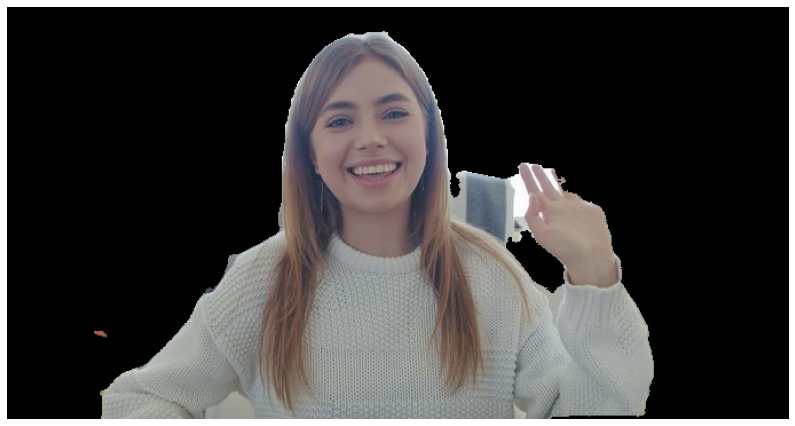

In [84]:
plt.figure(figsize=(14,8))
image = mpimg.imread("result_parallel.png")
plt.axis('off')
plt.imshow(image)
plt.show()

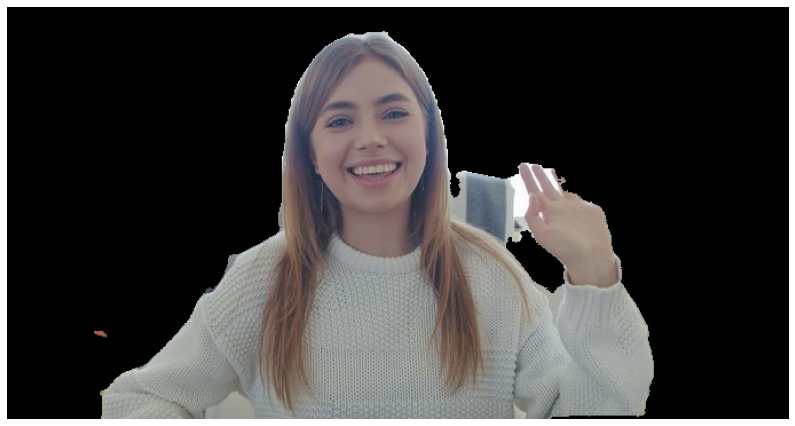

In [85]:
plt.figure(figsize=(14,8))
img_1 = mpimg.imread("Images/result_unet.png")
plt.axis('off')
plt.imshow(img_1)
plt.show()

In [86]:
np.abs(image - img_1).sum()

0.0

#### Thời gian chạy

In [87]:
pd.DataFrame(list(zip(func, time_compile_parallel, time_run_parallel, time_unet_parallel)),
               columns =['Name', 'Compile+Run', 'Run', 'Unet']).sort_values(by=['Unet'], ascending=False)

,Name,Compile+Run,Run,Unet
3,Conv2D,0.340150,0.040011,2.226572
5,Batch Norm,0.296019,0.024862,0.652654
0,Relu,0.286796,0.035453,0.506111
4,Conv2D Transpose,0.347962,0.039360,0.401456
6,Concat,0.247773,0.071954,0.337148
2,Maxpool2D,0.514127,0.027376,0.297274
1,Sigmoid,0.209993,0.032761,0.191519


Dựa trên bảng đánh giá tốc độ khi đã song song, nhóm sẽ thực hiện tối ưu hóa song song cho layer Conv2D.

#### Writefile Conv2d

In [88]:
before = np.array(x)
after = np.array(layer_outs[1])
weight = model.layers[1].weights[0].numpy()
bias = model.layers[1].weights[1].numpy()

np.save('input.npy', before)
np.save('weight.npy', weight)
np.save('bias.npy', bias)

In [89]:
%%writefile parallel_conv2d.py

import numpy as np
import cv2
import math
import time
from numba import jit, prange, config, cuda, float32
import pandas as pd

BLOCK_SIZE = (8, 8, 8)

def check(func, *arg):
    start = time.time()
    result = func(*arg)
    end = time.time()
    t = end - start
    return result, t

# Conv2D
@cuda.jit(debug=True)
def conv2D_parallel(input, wei, bias, stride,output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        k = wei.shape[1]
        c_in = input.shape[3]

        total=0.
        for c_i in range(c_in):
            kt=0.
            for k_x in range(k):
                for k_y in range(k):
                    pos1 = k_x + x * stride
                    pos2 = k_y + y * stride
                    kt += wei[k_x, k_y, c_i, z] * input[0, pos1, pos2, c_i]
            total += kt
        
        output[0, x, y, z] = total + bias[z]

def conv2D_host(before, weight, bias ,padding ="same", stride = 1):
  w_in, h_in, c_in = before.shape[1:4]

  k = weight.shape[1]
  pad = k // 2
  w_out = (w_in + 2 * pad - k)//stride + 1
  h_out = (h_in + 2 * pad - k)//stride + 1
  c_out = bias.shape[0]

  input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
  input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

  res = np.zeros((1, w_out, h_out, c_out))
  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _=conv2D_parallel[GRID_SIZE, BLOCK_SIZE]( input_pad,  weight, bias, stride,res)
  return res

before = np.load('input.npy')
weight = np.load('weight.npy')
bias = np.load('bias.npy')

# interpreter -> cached
res,t = check(conv2D_host,before[:1,:1], weight[:1,:1], bias[:1])

res,t = check(conv2D_host,before, weight, bias)
print(f'Processing time: {t} s')
np.save('res.npy', res)

Overwriting parallel_conv2d.py


In [90]:
!nvprof --print-gpu-trace python parallel_conv2d.py

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
==864== NVPROF is profiling process 864, command: python3 parallel_conv2d.py
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2D_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
Processing time: 

In [91]:
res = np.load('res.npy')
print("Checking difference",np.abs(res-after).mean())

Checking difference 1.000238593617159e-08


## Tối ưu song song phiên bản 1 [Convolution2D]

### Thiết kế
Vì numba sẽ tự động copy từ host sang device và ngược lại với tất cả dữ liệu được truyền vào hàm kernel, nên có thể bị tăng thời gian thực thi do copy thừa. \
Convolution2D:

*   cuda.to_device() các biến: input, weight, bias
*   array.copy_to_host() các biến: res



### Cài đặt 

In [110]:
%%writefile parallel_optimized1_conv2d.py
import numpy as np
import cv2
import math
import time
from numba import jit, prange, config, cuda, float32
import pandas as pd

BLOCK_SIZE = (8, 8, 8)

# Conv2D
@cuda.jit(debug=True)
def conv2D_parallel(input, wei, bias, stride,output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        k = wei.shape[1]
        c_in = input.shape[3]

        total=0.
        for c_i in range(c_in):
            kt=0.
            for k_x in range(k):
                for k_y in range(k):
                    pos1 = k_x + x * stride
                    pos2 = k_y + y * stride
                    kt += wei[k_x, k_y, c_i, z] * input[0, pos1, pos2, c_i]
            total += kt
        
        output[0, x, y, z] = total + bias[z]

def conv2D_host(before, weight, bias ,padding ="same", stride = 1):
  w_in, h_in, c_in = before.shape[1:4]

  k = weight.shape[1]
  pad = k // 2
  w_out = (w_in + 2 * pad - k)//stride + 1
  h_out = (h_in + 2 * pad - k)//stride + 1
  c_out = bias.shape[0]

  input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
  input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

  # Copy to device
  d_input_pad = cuda.to_device(input_pad)
  d_weight = cuda.to_device(weight)
  d_bias = cuda.to_device(bias)
  d_res = cuda.device_array((1, w_out, h_out, c_out), dtype = float)
  GRID_SIZE = (math.ceil(d_res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(d_res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(d_res.shape[3]/BLOCK_SIZE[2]))

  _=conv2D_parallel[GRID_SIZE, BLOCK_SIZE]( d_input_pad,  d_weight, d_bias, stride, d_res)
  # Copy to host
  res = d_res.copy_to_host()
  return res

def check(func, *arg):
    start = time.time()
    result = func(*arg)
    end = time.time()
    t = end - start
    return result, t
    
before = np.load('input.npy')
weight = np.load('weight.npy')
bias = np.load('bias.npy')

# interpreter -> cached
res,t = check(conv2D_host,before[:1,:1], weight[:1,:1], bias[:1])

res,t = check(conv2D_host,before, weight, bias)
print(f'Processing time: {t} s')

Overwriting parallel_optimized1_conv2d.py


In [111]:
!nvprof --print-gpu-trace python parallel_optimized1_conv2d.py

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))
==1169== NVPROF is profiling process 1169, command: python3 parallel_optimized1_conv2d.py
/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2D_parallel)
  warn(NumbaInvalidConfigWarning(msg))
Processing time: 0.02271103858947754 s
==1169== Profiling application: python3 parallel_optimized1_conv2d.py
==1169== Profiling result:
   Start  Duration            Grid Size      Block Size     Regs*    SSMem*    D

## Tối ưu song song phiên bản 2 [Convolution2D]

### Thiết kế

### Cài đặt 

In [112]:
%%writefile parallel_optimized2_conv2d.py
import numpy as np
import cv2
import math
import time
from numba import jit, prange, config, cuda, float32
import pandas as pd

BLOCK_SIZE = (32,32,32)

# Conv2D
@cuda.jit(debug=True)
def conv2D_parallel(input, wei, bias, stride,output):
    sIn = cuda.shared.array((34,34,32), dtype=output.dtype)
    
    x, y, z = cuda.grid(3)
    tx, ty, tz = cuda.threadIdx.x, cuda.threadIdx.y, cuda.threadIdx.z

    if x >= output.shape[1] or y >= output.shape[2] or z >= output.shape[3]:
      return
      
    tmp = 0.
    k = wei.shape[1]
    c_in = input.shape[3]
    for phase in range(math.ceil(c_in/32)):
        # Preload data into shared memory
        rS, cS, zS= x, y, tz + phase * 32
        
        if rS < input.shape[0] and cS < input.shape[1] and zS < input.shape[2]:
          sIn[tx, ty, tz] = input[rS, cS, zS]

        if tx==31 and rS+2<input.shape[0]:
          sIn[tx+1, ty, tz] = input[rS+1, cS, zS]
          sIn[tx+2, ty, tz] = input[rS+2, cS, zS]

        if ty==31 and cS+2<input.shape[1]:
          sIn[tx, ty+1, tz] = input[rS, cS+1, zS]
          sIn[tx, ty+2, tz] = input[rS, cS+2, zS]
          if tx==31 and rS+2<input.shape[0]:
            sIn[tx+1, ty+1, tz] = input[rS+1, cS+1, zS]
            sIn[tx+1, ty+2, tz] = input[rS+1, cS+2, zS]
            sIn[tx+2, ty+1, tz] = input[rS+2, cS+1, zS]
            sIn[tx+2, ty+2, tz] = input[rS+2, cS+2, zS]

        cuda.syncthreads()
        total = 0.
        for c_i in range(32):
            kt=0.
            for k_x in range(k):
                for k_y in range(k):
                    pos1 = k_x + tx * stride
                    pos2 = k_y + ty * stride
                    kt += wei[k_x, k_y, phase*32+c_i, z] * sIn[0, pos1, pos2, c_i]
            total += kt
        cuda.syncthreads()
    output[0, x, y, z] = total + bias[z]

def conv2D_host(before, weight, bias ,padding ="same", stride = 1):
  w_in, h_in, c_in = before.shape[1:4]

  k = weight.shape[1]
  pad = k // 2
  w_out = (w_in + 2 * pad - k)//stride + 1
  h_out = (h_in + 2 * pad - k)//stride + 1
  c_out = bias.shape[0]

  input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
  input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

  # Copy to device
  d_input_pad = cuda.to_device(input_pad)
  d_weight = cuda.to_device(weight)
  d_bias = cuda.to_device(bias)
  d_res = cuda.device_array((1, w_out, h_out, c_out), dtype = float)
  GRID_SIZE = (math.ceil(d_res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(d_res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(d_res.shape[3]/BLOCK_SIZE[2]))

  _=conv2D_parallel[GRID_SIZE, BLOCK_SIZE]( d_input_pad,  d_weight, d_bias, stride, d_res)
  # Copy to host
  res = d_res.copy_to_host()
  return res

def check(func, *arg):
    start = time.time()
    result = func(*arg)
    end = time.time()
    t = end - start
    return result, t
    
before = np.load('input.npy')
weight = np.load('weight.npy')
bias = np.load('bias.npy')

# interpreter -> cached
res,t = check(conv2D_host,before[:1,:1], weight[:1,:1], bias[:1])

res,t = check(conv2D_host,before, weight, bias)
print(f'Processing time: {t} s')

Overwriting parallel_optimized2_conv2d.py


In [113]:
!nvprof --print-gpu-trace python parallel_optimized2_conv2d.py

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))
==1197== NVPROF is profiling process 1197, command: python3 parallel_optimized2_conv2d.py
/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
Traceback (most recent call last):
  File "parallel_optimized2_conv2d.py", line 95, in <module>
    res,t = check(conv2D_host,before[:1,:1], weight[:1,:1], bias[:1])
  File "parallel_optimized2_conv2d.py", line 85, in check
    result = func(*arg)
  File "parallel_optimized2_conv2d.py", line 78, in conv2D_host
    _=conv2D_parallel[GRID_SIZE, BLOCK_SIZE]( d_input_pad,  d_weight, d_bias, stride, d_res)
  File "/usr/local/lib/python3.7/dist-

## Mô hình Unet đã tối ưu song song

In [96]:
%%writefile parallel_optimized_1.py
from tensorflow import keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, MaxPool2D
import numpy as np
import cv2
from keras import backend as K
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import math
import time
from numba import jit, prange, config, cuda, float32
import pandas as pd

BLOCK_SIZE = (8, 8, 8)

def check(func, *arg):
    result = func(*arg)
    return result, 0

# RELU
@cuda.jit(debug=True) 
def relu_parallel(input, output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        if input[0, x, y, z] < 0: 
            output[0, x, y, z] = 0
        else: output[0, x, y, z] = input[0, x, y, z]

def relu_host(before):
  res = np.zeros((before.shape), dtype=float)
  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _ = relu_parallel[GRID_SIZE, BLOCK_SIZE](before, res)
  return res

# SIGMOID
@cuda.jit(debug=True) 
def sigmoid_parallel(input, output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        output[0, x, y, z] = 1 / (1 + math.exp(-input[0, x, y, z]))

def sigmoid_host(before):
  res = np.zeros((before.shape), dtype=float)
  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _ = sigmoid_parallel[GRID_SIZE, BLOCK_SIZE]( before, res)
  return res

# MaxPool2D
@cuda.jit(debug=True)
def maxpool2d_parallel(input, output, pool, stride):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        col = x * stride
        row = y * stride

        max = input[0, col, row, z]
        for i in range(pool):
            for j in range(pool):
                if input[0, col + i, row + j, z] > max:
                    max = input[0, col + i, row + j, z]

        output[0, x, y, z] = max

def maxpool2d_host(before, pool = 2, stride = 2):
  w_out = (before.shape[1] - pool)//stride + 1
  h_out = (before.shape[2] - pool)//stride + 1
  res = np.zeros((1, w_out, h_out, before.shape[3]))

  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _ = maxpool2d_parallel[GRID_SIZE, BLOCK_SIZE]( before, res, pool, stride)
  return res
  
# Conv2D
@cuda.jit(debug=True)
def conv2D_parallel(input, wei, bias, stride,output):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        k = wei.shape[1]
        c_in = input.shape[3]

        total=0.
        for c_i in range(c_in):
            kt=0.
            for k_x in range(k):
                for k_y in range(k):
                    pos1 = k_x + x * stride
                    pos2 = k_y + y * stride
                    kt += wei[k_x, k_y, c_i, z] * input[0, pos1, pos2, c_i]
            total += kt
        
        output[0, x, y, z] = total + bias[z]

def conv2D_host(before, weight, bias ,padding ="same", stride = 1):
  w_in, h_in, c_in = before.shape[1:4]

  k = weight.shape[1]
  pad = k // 2
  w_out = (w_in + 2 * pad - k)//stride + 1
  h_out = (h_in + 2 * pad - k)//stride + 1
  c_out = bias.shape[0]

  input_pad = np.zeros((1, w_in + 2 * pad, h_in + 2 * pad, c_in))
  input_pad[0, pad:(w_in + pad), pad:(h_in + pad), :] = before

  res = np.zeros((1, w_out, h_out, c_out))
  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _=conv2D_parallel[GRID_SIZE, BLOCK_SIZE]( input_pad,  weight, bias, stride,res)
  return res

# Conv2D Transpose
@cuda.jit(debug=True)
def conv2Dtranspose_parallel(input, output, wei, bias, stride):
    x, y, z = cuda.grid(3)

    if x < output.shape[1] and y < output.shape[2] and z < output.shape[3]:
        # k = wei.shape[1]
        c_in = input.shape[3]

        total=0.
        k_x = x % stride
        k_y = y % stride
        for c_i in range(c_in):
            total += wei[k_x, k_y, z, c_i] * input[0, x // stride, y // stride, c_i]
        
        output[0, x, y, z] = total + bias[z]

def conv2Dtranspose_host(before, weight, bias,padding="same" , stride = 1):
  w_in, h_in, c_in = before.shape[1:4]

  stride = 2
  k = weight.shape[1]
  w_out = w_in * stride
  h_out = h_in * stride
  c_out = bias.shape[0]

  res = np.zeros((1, w_out, h_out, c_out))
  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _ = conv2Dtranspose_parallel[GRID_SIZE, BLOCK_SIZE]( before, res, weight, bias, stride)
  return res

# BatchNormalization
@cuda.jit(debug=True)
def batchNorm_parallel(X, eps, gamma, beta, moving_mean, moving_var, res):
    i,j,d = cuda.grid(3)

    res[0,i,j,d] = (gamma[d]*(res[0,i,j,d] - moving_mean[d]) / math.sqrt(moving_var[d] + eps))+ beta[d]

def batchNorm_host(before, gamma, beta, moving_mean,moving_var):
  eps = 0.001
  res = before.copy()

  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))

  _ = batchNorm_parallel[GRID_SIZE, BLOCK_SIZE]( before, eps, gamma, beta, moving_mean, moving_var, res)
  return res

# concatenate
@cuda.jit(debug=True)
def concat_parallel(skip_features, x, res):
    i,j,d = cuda.grid(3)
    
    if d<x.shape[3]:
      res[0,i,j,d] = x[0,i,j,d]
    else:
      res[0,i,j,d] = skip_features[0,i,j,d-x.shape[3]]

def concat_host(skip_features,before):
  w_in, h_in, c_in = before.shape[1] ,before.shape[2] ,before.shape[3]
  res = np.zeros((1,w_in, h_in, c_in*2))

  GRID_SIZE = (math.ceil(res.shape[1]/BLOCK_SIZE[0]),
              math.ceil(res.shape[2]/BLOCK_SIZE[1]),
              math.ceil(res.shape[3]/BLOCK_SIZE[2]))
  _ = concat_parallel[GRID_SIZE, BLOCK_SIZE]( skip_features, before,res)
  return res

# Model Parallel 
def conv_block(inputs, index):
    x, t = check(conv2D_host, inputs, weights[index]["wei"], weights[index]["bias"], 'same')
    x, t = check(batchNorm_host, x, weights[index+1]["gamma"], weights[index+1]["beta"], weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    x, t = check(relu_host, x)

    index += 3
    x, t = check(conv2D_host, x, weights[index]["wei"], weights[index]["bias"], 'same')
    x, t = check(batchNorm_host, x, weights[index+1]["gamma"], weights[index+1]["beta"], weights[index+1]["moving_mean"], weights[index+1]["moving_var"])
    x, t = check(relu_host, x)
    
    return x

def encoder_block(inputs, index):
    x = conv_block(inputs, index)
    p, t = check(maxpool2d_host, x)
    return x, p

def decoder_block(inputs, skip_features, index):
    x, t = check(conv2Dtranspose_host, inputs, weights[index]["wei"], weights[index]["bias"], "same", 2)
    x, t = check(concat_host, skip_features, x)
    x = conv_block(x, index + 2)
    return x

def build_unet(X):
    index = 1
    """ Encoder """
    s1, p1 = encoder_block( X, index ) #64
    index += 7
    s2, p2 = encoder_block( p1, index ) #128
    index += 7
    s3, p3 = encoder_block( p2, index ) #256
    index += 7
    s4, p4 = encoder_block( p3, index ) #512
    index += 7
    b1 = conv_block( p4, index ) #1024
    index += 6
    """ Decoder """
    d1 = decoder_block( b1, s4, index ) #512
    index += 8
    d2 = decoder_block( d1, s3, index ) #256
    index += 8
    d3 = decoder_block( d2, s2, index ) #128
    index += 8
    d4 = decoder_block( d3, s1, index ) #64 
    index += 8

    """ Output """
    # outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    flatten, t = check(conv2D_host, d4, weights[index]["wei"], weights[index]["bias"], "same", 1)
    outputs, t = check(sigmoid_host, flatten)
    return outputs

def read_image(path):
    origin_img = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = origin_img.shape
    x = cv2.resize(origin_img, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    # (256, 256, 3)
    return x, w, h, origin_img

def to_dev(x):
  return cuda.to_device(x)

# Read input and build model
c_x, x_w, x_h, origin_img = read_image("./Images/zoom5.jpg")
c_x = np.expand_dims(c_x, axis=0)

model = tf.keras.models.load_model("./Model_20/unet.h5")

# load weight to dictionary
weights = {}
for i, layer in enumerate(model.layers):
    if "conv2d_transpose" in layer.name: 
        weights[i] = {"name":layer.name, "wei": to_dev(layer.weights[0].numpy()),"bias": to_dev(layer.weights[1].numpy())} 
    elif "conv2d" in layer.name: 
        weights[i] = {"name":layer.name, "wei": to_dev(layer.weights[0].numpy()),"bias": to_dev(layer.weights[1].numpy())}
    elif "batch_normalization" in layer.name:
        weights[i] = {"name":layer.name,
                      "gamma":to_dev(layer.weights[0].numpy()),
                      "beta":to_dev(layer.weights[1].numpy()), 
                      "moving_mean":to_dev(layer.weights[2].numpy()),
                      "moving_var":to_dev(layer.weights[3].numpy())}

x = cuda.to_device(c_x)
dC = cuda.device_array((x.shape[0], x.shape[1]), dtype = int)

start = time.time()
pred = build_unet(x)

end = time.time()
print(f'Processing time: {end - start} s')


pred_mask = cv2.resize(pred[0], (x_w, x_h))
pred_mask = np.expand_dims(pred_mask, axis=-1)
pred_mask = pred_mask > 0.5

background_mask = np.abs(1- pred_mask)
    
masked_image = origin_img * pred_mask

background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
background_mask = background_mask * [0, 0, 0]

masked_image = masked_image + background_mask
cv2.imwrite("result_parallel_optimize_1.png", masked_image)

Overwriting parallel_optimized_1.py


In [97]:
!nvprof --print-gpu-trace python parallel_optimized_1.py

/usr/local/lib/python3.7/dist-packages/numba/cuda/decorators.py:80: NumbaInvalidConfigWarning: debug=True with opt=True (the default) is not supported by CUDA. This may result in a crash - set debug=False or opt=False.
  warn(NumbaInvalidConfigWarning(msg))
==923== NVPROF is profiling process 923, command: python3 parallel_optimized_1.py
2022-08-02 20:41:41.827380: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.7/dist-packages/numba/cuda/codegen.py:126: NumbaInvalidConfigWarning: debuginfo is not generated for CUDA versions < 11.2 (debug=True on function: conv2D_parallel)
  warn(NumbaInvalidConfigWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr

## Tham khảo
Phần code tuần tự:
1. https://betterdatascience.com/implement-pooling-from-scratch-in-python/
2. https://d2l.ai/chapter_computer-vision/transposed-conv.html
3. http://d2l.ai/chapter_convolutional-modern/batch-norm.html?highlight=batchnorm

Phần code song song:


Ngoài ra:
https://www.kaggle.com/getting-started/253300

